# Shakespeare ML

This is a dataset consisting of the complete works of Shakespeare. This dataset was created by Andrej Karpathy for <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'>this</a> blog post and is available on <a href='https://github.com/karpathy/char-rnn/blob/master/data/tinyshakespeare/input.txt'>this</a> github page.

## Imports

In [1]:
import matplotlib.pyplot as plt
import re
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
from tensorflow_text.tools.wordpiece_vocab.bert_vocab_from_dataset import bert_vocab_from_dataset
import textwrap

plt.style.use('dark_background')

## Helper Functions

In [22]:
def plot_training_metrics(history):
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.suptitle('Model Training')
    plt.legend()
    plt.show()

def save_best_model(model, test_ds, filename):

    try:
        saved_model = tf.keras.models.load_model(filename)
    except:
        saved_model = None

    if saved_model:
        print('Saved Model Evaluation:')
        saved_model_metrics = saved_model.evaluate(test_ds, return_dict=True)
        print('New Model Evaluation:')
        new_model_metrics = model.evaluate(test_ds, return_dict=True)
        if new_model_metrics['loss'] < saved_model_metrics['loss']:
            model.save(filename, save_traces=False)
    else:
        print('New Model Evaluation:')
        model_metrics = model.evaluate(test_ds)
        model.save(filename, save_traces=False)

## Character Based Approach

### Loading and Processing the Dataset

In [3]:
char_batch_size = 128
char_sequence_length = 100

AUTOTUNE = tf.data.AUTOTUNE

test_ds, train_ds, validation_ds = tfds.load('tiny_shakespeare', split=['test', 'train', 'validation'])
train_text = next(train_ds.as_numpy_iterator())['text'].decode()
print('Train Dataset Preview:')
print(textwrap.indent(train_text[:200], ' ' * 4))

vocab = sorted(set(train_text))
char_encoder = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=vocab
)
char_decoder = tf.keras.layers.experimental.preprocessing.StringLookup(
    invert=True,
    vocabulary=vocab
)
char_vocab_size = len(char_encoder.get_vocabulary())

def process_ds(ds):
    ds = ds.flat_map(lambda data: tf.data.Dataset.from_tensor_slices(char_encoder(tf.strings.unicode_split(data['text'], input_encoding='UTF-8'))))
    ds = ds.window(char_sequence_length+1, drop_remainder=True, shift=1)
    ds = ds.flat_map(lambda window: window.batch(char_sequence_length+1))
    ds = ds.map(lambda sequence: (sequence[:-1], sequence[-1]), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(char_batch_size)
    ds = ds.shuffle(1000)
    ds = ds.prefetch(AUTOTUNE)
    return ds

char_test_ds = process_ds(test_ds)
char_train_ds = process_ds(train_ds)
char_validation_ds = process_ds(validation_ds)

Train Dataset Preview:
    First Citizen:
    Before we proceed any further, hear me speak.

    All:
    Speak, speak.

    First Citizen:
    You are all resolved rather to die than to famish?

    All:
    Resolved. resolved.

    First Citizen:
    First, you


### Creating the Model

In [8]:
# Best Model (char_sequence_length=100)
# char_model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(
#         input_dim=char_vocab_size,
#         output_dim=64
#     ),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
#     tf.keras.layers.Dense(char_vocab_size)
# ])

char_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=char_vocab_size,
        output_dim=64
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    tf.keras.layers.Dense(char_vocab_size)
])
char_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam()
)

### Training the Model

In [9]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    mode='min',
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
char_history = char_model.fit(
    char_train_ds,
    callbacks=[early_stopping_callback],
    epochs=100,
    validation_data=char_validation_ds
)

Epoch 1/100
7842/7842 [==============================] - 327s 39ms/step - loss: 1.7724 - sparse_categorical_accuracy: 0.4813 - val_loss: 1.5775 - val_sparse_categorical_accuracy: 0.5354
Epoch 2/100
7842/7842 [==============================] - 330s 40ms/step - loss: 1.4381 - sparse_categorical_accuracy: 0.5644 - val_loss: 1.4908 - val_sparse_categorical_accuracy: 0.5558
Epoch 3/100
7842/7842 [==============================] - 328s 40ms/step - loss: 1.3576 - sparse_categorical_accuracy: 0.5840 - val_loss: 1.4632 - val_sparse_categorical_accuracy: 0.5632
Epoch 4/100
7842/7842 [==============================] - 332s 40ms/step - loss: 1.3142 - sparse_categorical_accuracy: 0.5950 - val_loss: 1.4346 - val_sparse_categorical_accuracy: 0.5736
Epoch 5/100
7842/7842 [==============================] - 336s 41ms/step - loss: 1.2854 - sparse_categorical_accuracy: 0.6020 - val_loss: 1.4299 - val_sparse_categorical_accuracy: 0.5746
Epoch 6/100
7842/7842 [==============================] - 330s 40ms/ste

### Plotting Training Metrics and Saving the Best Model

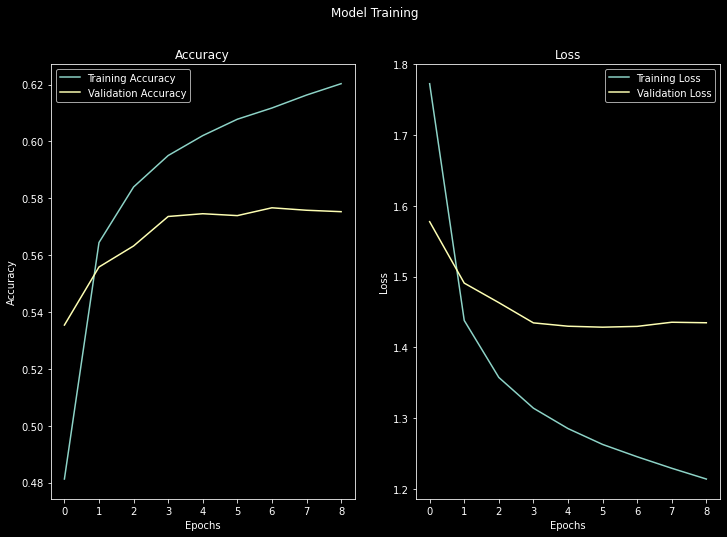

Saved Model Evaluation:
435/435 [==============================] - 26s 41ms/step - loss: 1.5901 - sparse_categorical_accuracy: 0.5497
New Model Evaluation:
435/435 [==============================] - 14s 16ms/step - loss: 1.5879 - sparse_categorical_accuracy: 0.5413
INFO:tensorflow:Assets written to: models\Character_LSTM\assets


INFO:tensorflow:Assets written to: models\Character_LSTM\assets


In [15]:
plot_training_metrics(char_history)
save_best_model(char_model, char_test_ds, 'models\\Character_LSTM')

### Generating Text with the Best Model

In [16]:
length_to_generate = 1000
starting_string = 'And then'

best_model = tf.keras.models.load_model('models\\Character_LSTM')
generated_text = starting_string
for i in range(length_to_generate):
    if len(generated_text) > char_sequence_length:
        prediction_string = generated_text[-char_sequence_length:]
    else:
        prediction_string = generated_text
    prediction_ids = tf.transpose(tf.expand_dims(char_encoder(list(prediction_string)), axis=1))
    predicted_logits = best_model(prediction_ids)
    predicted_index = tf.random.categorical(predicted_logits, num_samples=1)
    generated_text += char_decoder(predicted_index).numpy()[0][0].decode()

print('Generated Text:')
print(generated_text)

Generated Text:
And then? I will kept all to so.

TRANION:
Put me that?

DUKE VINCENTIO:
Hark, has with been earthly.

LUCIO:
That, is the vice till redy much born such towards:
Forey't in's something reason play to her.
Which ha?

LEONTES:
O, must be morn toward me so?

PETRUCHIO:
Lidty cowers, we? Meaning to be dead?
Master, of Blandows must swear: but let's no more:
How use offence it told upon such noyed;
It safforn the willed honest pompey?

KING RICHARD III:
A rock, makes my suit?

First Gentleman:
O, say, if we would go with you death than my love,
No hands with a respecter and not meet repried
For, sweet bereft; or be about him nor come
A blade a whence i' the young rightly breaths,
Which know you deceived?

LEONTES:
A bawn, do you be rough, sir,--

MARIANA:
'Uwn malab
Than Bestitil master alone ignoran;
And all their sin velpenties men,
Sometimes his sorrow, bear him against the gliet
Till he whore the meting
Did unemporing; but in the issue of a
Harrand, implexence there like

## Word Based Approach

### Loading and Processing the Dataset

In [17]:
word_batch_size = 128
word_sequence_length = 25
word_vocab_size = 1000

AUTOTUNE = tf.data.AUTOTUNE

test_ds, train_ds, validation_ds = tfds.load('tiny_shakespeare', split=['test', 'train', 'validation'])

train_text = next(train_ds.as_numpy_iterator())['text'].decode()
word_encoder = tf.keras.layers.experimental.preprocessing.StringLookup(max_tokens=word_vocab_size)
word_encoder.adapt(re.findall(r"[\w']+|[.,!?;:\n]", train_text)) # This regex splits the text into words and punctuation
word_decoder = tf.keras.layers.experimental.preprocessing.StringLookup(
    invert=True,
    vocabulary=word_encoder.get_vocabulary()
)

def process_ds(ds):
    ds_text = next(ds.as_numpy_iterator())['text'].decode().lower()
    ds = tf.data.Dataset.from_tensor_slices(word_encoder(re.findall(r"[\w']+|[.,!?;:\n]", ds_text)))
    ds = ds.window(word_sequence_length+1, drop_remainder=True, shift=1)
    ds = ds.flat_map(lambda window: window.batch(word_sequence_length+1))
    ds = ds.map(lambda sequence: (sequence[:-1], sequence[-1]), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(word_batch_size)
    ds = ds.shuffle(1000)
    ds = ds.prefetch(AUTOTUNE)
    return ds

word_test_ds = process_ds(test_ds)
word_train_ds = process_ds(train_ds)
word_validation_ds = process_ds(validation_ds)

### Creating the Model

In [18]:
# Best Model
# word_model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(
#         input_dim=word_vocab_size,
#         output_dim=64
#     ),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
#     tf.keras.layers.Dense(word_vocab_size)
# ])

word_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=word_vocab_size,
        output_dim=64
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    tf.keras.layers.Dense(word_vocab_size)
])
word_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam()
)

### Training the Model

In [19]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    mode='min',
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
word_history = word_model.fit(
    word_train_ds,
    callbacks=[early_stopping_callback],
    epochs=100,
    validation_data=word_validation_ds
)

Epoch 1/100
2034/2034 [==============================] - 40s 14ms/step - loss: 3.7004 - sparse_categorical_accuracy: 0.3269 - val_loss: 3.2215 - val_sparse_categorical_accuracy: 0.3891
Epoch 2/100
2034/2034 [==============================] - 37s 14ms/step - loss: 3.3347 - sparse_categorical_accuracy: 0.3601 - val_loss: 3.0857 - val_sparse_categorical_accuracy: 0.3963
Epoch 3/100
2034/2034 [==============================] - 36s 14ms/step - loss: 3.2040 - sparse_categorical_accuracy: 0.3705 - val_loss: 3.0185 - val_sparse_categorical_accuracy: 0.4020
Epoch 4/100
2034/2034 [==============================] - 38s 14ms/step - loss: 3.1048 - sparse_categorical_accuracy: 0.3787 - val_loss: 2.9744 - val_sparse_categorical_accuracy: 0.4073
Epoch 5/100
2034/2034 [==============================] - 37s 14ms/step - loss: 3.0193 - sparse_categorical_accuracy: 0.3841 - val_loss: 2.9748 - val_sparse_categorical_accuracy: 0.4112
Epoch 6/100
2034/2034 [==============================] - 36s 13ms/step - lo

### Plotting Training Metrics and Saving the Best Model

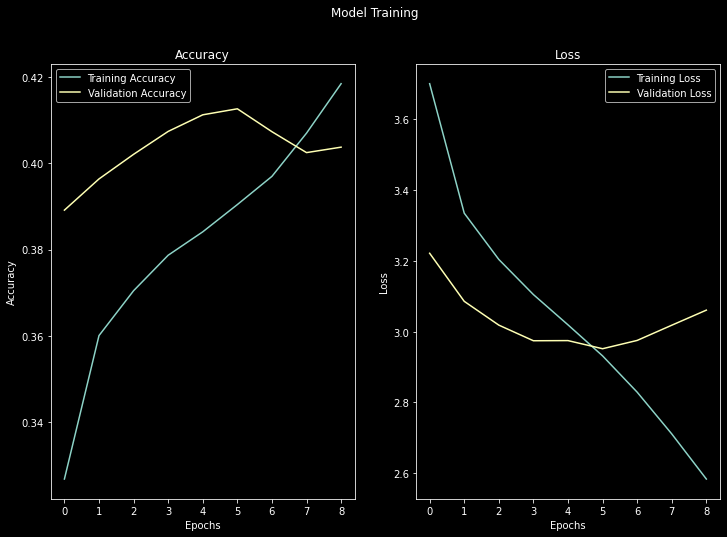

Saved Model Evaluation:
117/117 [==============================] - 3s 12ms/step - loss: 2.9937 - sparse_categorical_accuracy: 0.4125
New Model Evaluation:
117/117 [==============================] - 2s 6ms/step - loss: 3.0136 - sparse_categorical_accuracy: 0.4107


In [20]:
plot_training_metrics(word_history)
save_best_model(word_model, word_test_ds, 'models\\Word_LSTM')

### Generating Text

In [21]:
length_to_generate = 250
starting_string = 'And then'

best_model = tf.keras.models.load_model('models\\Word_LSTM')
generated_text = starting_string
for i in range(length_to_generate):
    if len(generated_text) > word_sequence_length:
        prediction_string = generated_text[-word_sequence_length:]
    else:
        prediction_string = generated_text
    prediction_ids = tf.transpose(tf.expand_dims(word_encoder(prediction_string.split()), axis=1))
    predicted_logits = best_model(prediction_ids)
    predicted_index = tf.random.categorical(predicted_logits, num_samples=1)
    word_to_add = word_decoder(predicted_index).numpy()[0][0].decode()
    if re.search(r'[.,!?;:\n]', word_to_add):
        generated_text += word_to_add
    else:
        generated_text += ' ' + word_to_add

print('Generated Text:')
print(generated_text)

Generated Text:
And then spoke follow me with [UNK],,,:;,,.,. [UNK] the other men,, brother
?






 is he not yet way at [UNK]:: to me
 behold [UNK].:,? and old
 less suit?:, [UNK]
,

 duke could [UNK] the king young,!? [UNK] voice! far land


 that long the fault of his [UNK];; [UNK],:?,,.?.,? mortal charge themselves.,? are present [UNK];,
 all,
 heaven!

.
 what often pray you,?, to way with the [UNK] of my heart,
,

 but not high [UNK] [UNK]: to [UNK] [UNK]!!,?: [UNK]..:!!, hours, them by the while your son did made me
 good:
:
 but [UNK] saw another [UNK],..,
;






 but had their [UNK] [UNK] did his
 business
 were made
 our [UNK],: can [UNK]:
 her:
 to them thus [UNK] here., up.. [UNK],??:: with [UNK] last [UNK] [UNK],;, than a [UNK] spirit,,


On this task the character model seems to do better than the word model. Both are largely nonsensical but the character model less so. However, the word model may be limited by our limited vocabulary size of 1000 words. This doesn't excuse or explain its tendency to have multiple punctuation marks in a row, but may limit how effective training can be since many words in the training text will be represented by the [UNK] token.

## Subword Based Approach

### Loading and Processing the Dataset

In [2]:
reserved_tokens = ['[PAD]', '[UNK]', '[START]', '[END]']
subword_batch_size = 128
subword_sequence_length = 25
subword_vocab_size = 2000

AUTOTUNE = tf.data.AUTOTUNE

#### Generating the Vocabulary

In [3]:
train_ds = tfds.load('tiny_shakespeare', split=['train'])
train_ds = train_ds[0]

ds_text = next(train_ds.as_numpy_iterator())['text'].decode().lower()
tokenizer = tf_text.WhitespaceTokenizer()
ds = tf.data.Dataset.from_tensor_slices(tokenizer.tokenize(ds_text))
bert_tokenizer_params = {'lower_case':True}
vocab = bert_vocab_from_dataset(ds, subword_vocab_size, reserved_tokens, bert_tokenizer_params=bert_tokenizer_params)

with open('vocab.txt', 'w') as f:
    for token in vocab:
        print(token, file=f)

Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


#### Processing the Datasets

In [19]:
test_ds, train_ds, validation_ds = tfds.load('tiny_shakespeare', split=['test', 'train', 'validation'])

tokenizer = tf_text.WhitespaceTokenizer()
subtokenizer = tf_text.WordpieceTokenizer('vocab.txt')

def process_ds(ds):
    ds_text = next(ds.as_numpy_iterator())['text'].decode().lower()
    ds = tf.data.Dataset.from_tensor_slices(subtokenizer.tokenize(tokenizer.tokenize(ds_text)))
    ds = ds.flat_map(lambda element: tf.data.Dataset.from_tensor_slices(element))
    ds = ds.window(subword_sequence_length+1, drop_remainder=True, shift=1)
    ds = ds.flat_map(lambda window: window.batch(subword_sequence_length+1))
    ds = ds.map(lambda sequence: (sequence[:-1], sequence[-1]), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(subword_batch_size)
    ds = ds.shuffle(1000)
    ds = ds.prefetch(AUTOTUNE)
    return ds

subword_test_ds = process_ds(test_ds)
subword_train_ds = process_ds(train_ds)
subword_validation_ds = process_ds(validation_ds)

### Creating a Model

In [18]:
# Best Model
# subword_model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(
#         input_dim=subword_vocab_size,
#         output_dim=64
#     ),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
#     tf.keras.layers.Dense(subword_vocab_size)
# ])

subword_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=subword_vocab_size,
        output_dim=64
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    tf.keras.layers.Dense(subword_vocab_size)
])
subword_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam()
)

### Training the Model

In [20]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    mode='min',
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
subword_history = subword_model.fit(
    subword_train_ds,
    callbacks=[early_stopping_callback],
    epochs=100,
    validation_data=subword_validation_ds
)

Epoch 1/100
2269/2269 [==============================] - 53s 16ms/step - loss: 5.4384 - sparse_categorical_accuracy: 0.1036 - val_loss: 4.9430 - val_sparse_categorical_accuracy: 0.1364
Epoch 2/100
2269/2269 [==============================] - 49s 16ms/step - loss: 4.7964 - sparse_categorical_accuracy: 0.1488 - val_loss: 4.6829 - val_sparse_categorical_accuracy: 0.1564
Epoch 3/100
2269/2269 [==============================] - 49s 16ms/step - loss: 4.5253 - sparse_categorical_accuracy: 0.1698 - val_loss: 4.5518 - val_sparse_categorical_accuracy: 0.1694
Epoch 4/100
2269/2269 [==============================] - 50s 16ms/step - loss: 4.2963 - sparse_categorical_accuracy: 0.1891 - val_loss: 4.4629 - val_sparse_categorical_accuracy: 0.1705
Epoch 5/100
2269/2269 [==============================] - 49s 16ms/step - loss: 4.0810 - sparse_categorical_accuracy: 0.2086 - val_loss: 4.4371 - val_sparse_categorical_accuracy: 0.1770
Epoch 6/100
2269/2269 [==============================] - 48s 15ms/step - lo

### Plotting Training Metrics and Saving the Best Model

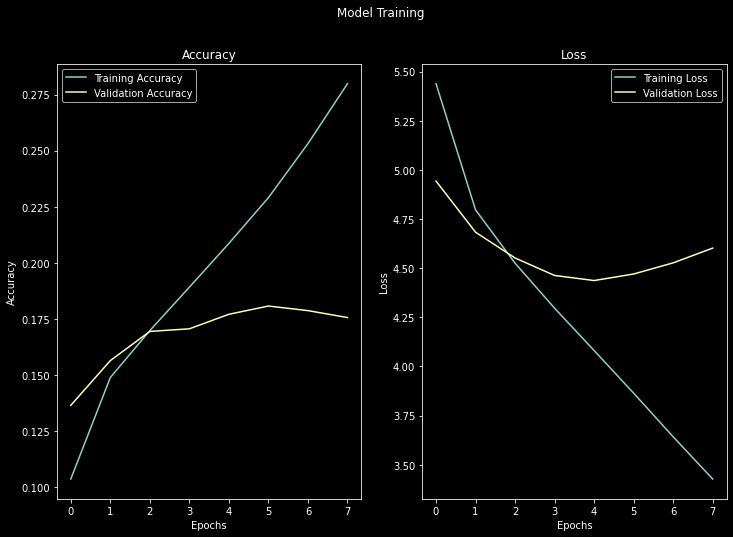

Saved Model Evaluation:
141/141 [==============================] - 4s 8ms/step - loss: 4.7404 - sparse_categorical_accuracy: 0.1586
New Model Evaluation:
141/141 [==============================] - 3s 6ms/step - loss: 4.6026 - sparse_categorical_accuracy: 0.1651
INFO:tensorflow:Assets written to: models\Subword_LSTM\assets


INFO:tensorflow:Assets written to: models\Subword_LSTM\assets


In [23]:
plot_training_metrics(subword_history)
save_best_model(subword_model, subword_test_ds, 'models\\Subword_LSTM')

### Generating Text

In [24]:
length_to_generate = 300
starting_string = 'And then'

tokenizer = tf_text.WhitespaceTokenizer()
subtokenizer = tf_text.WordpieceTokenizer('vocab.txt')
starting_tokens = subtokenizer.tokenize(tokenizer.tokenize(starting_string.lower()))
best_model = tf.keras.models.load_model('models\\Subword_LSTM')
generated_tokens = [item.numpy() for sublist in starting_tokens for item in sublist]
for i in range(length_to_generate):
    if len(generated_tokens) > subword_sequence_length:
        prediction_tokens = generated_tokens[-subword_sequence_length:]
    else:
        prediction_tokens = generated_tokens
    prediction_ids = tf.transpose(tf.expand_dims(prediction_tokens, axis=1))
    predicted_logits = best_model(prediction_ids)
    predicted_index = tf.random.categorical(predicted_logits, num_samples=1)
    generated_tokens.append(predicted_index.numpy()[0][0])
generated_text = subtokenizer.detokenize([generated_tokens])
generated_text_list = [item.numpy().decode() for sublist in generated_text for item in sublist]
generated_text = ' '.join(generated_text_list)

print('Generated Text:')
print(generated_text)

Generated Text:
and then bid sorrow. oath thee, i cannot speak thee: thou wouldst there live again. rivers: a mother, new rest fast with sort and uneqyory. my sweet lord! as mured sake me, king, knows you have fitted you than? duke of york: has not some well in soundion of your point? buckingham: let we be hither: 've's weeping intend on antires. king richard ii: shame out upon thy sorrow. duke vincentio: you, your lordship; who may die her. duke vincentio: you tell him, buckingham; it is come to look you than my grieved are. mariana: come you, i beseech you? juliet: you may will required me well. duke vincentio: it must a your leposition i dream withst, and anon-ever viy other bids is the taant, of self of delightable mistakes. yet lies me-- both blesss from cogot, where late loars to robbing foot' hand doth she wast from thy sad and terror: i am born to such geet for her so land. answer me to the place of my sacred estrand, proation to the duke: and cannot seem him, for my life, and 